In [ ]:
# !git clone https://github.com/YuanGongND/cav-mae.git
# %cd cav-mae

# Install packages
!pip install timm==0.4.5 torch torchvision torchaudio numpy==1.23.5 scipy==1.10.1 librosa==0.10.0.post2 scikit-learn matplotlib

In [2]:
# Imports
import torch
import torchaudio
import torchvision
import numpy as np

import sys
import torch 

sys.path.append('./cav-mae/src')

from models.cav_mae import CAVMAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize CAV-MAE model
model = CAVMAE(audio_length=1024, modality_specific_depth=11, norm_pix_loss=True, tr_pos=False)
model = torch.nn.DataParallel(model)

A CAV-MAE Model
Use norm_pix_loss:  True
Learnable Positional Embedding:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])


In [ ]:
# Load the pretrained checkpoint for CAV-MAE
checkpoint_path = "audio_model.pth"
ckpt = torch.load(checkpoint_path, map_location=device)

# Load weights into the model
missing, unexpected = model.load_state_dict(ckpt, strict=False)
print("Missing keys:", missing, "\nUnexpected keys:", unexpected)

model.to(device)
model.eval()


In [4]:
# # Extract audio to WAV and video frames (1 frame per second)]
# !mkdir -p frames
# !ffmpeg -y -i movie.mp4 -q:a 0 -map a movie.wav   # extract audio track
# !ffmpeg -y -i movie.mp4 -r 1 frames/frame_%04d.jpg   # extract 1 FPS frames

In [5]:
import librosa

# Load the full audio waveform
y, sr = librosa.load("movie.wav", sr=None)  # use native sampling rate
duration = int(librosa.get_duration(y=y, sr=sr))
print(f"Audio duration: {duration} seconds")


Audio duration: 3655 seconds


In [6]:
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
import os

# Mel-spectrogram: 128 mel bins, up to 1024 time steps
mel_spec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=1024,
    hop_length=256,
    n_mels=128
).to(device)

# Image preprocessing: resize to 224x224 and normalize like ImageNet
img_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [7]:
embeddings = []  # Save the 768-dim AV embedding for each second

for t in tqdm(range(1, duration + 1)):
    # Grab 1 second of audio from (t-1) to t
    start_sample = (t - 1) * sr
    end_sample = t * sr
    audio_seg = y[start_sample:end_sample]
    if len(audio_seg) < sr:
        audio_seg = np.pad(audio_seg, (0, sr - len(audio_seg))) # pad if shorter than 1s

    audio_tensor = torch.from_numpy(audio_seg).float().to(device)

    # Get mel-spectrogram and make sure it's shaped [1, 128, 1024]
    mel_spec = mel_spec_transform(audio_tensor).squeeze()
    if mel_spec.ndim == 2:
        mel_spec = mel_spec.unsqueeze(0)  # [1, 128, T]
    T_cur = mel_spec.shape[-1]
    if T_cur < 1024:
        mel_spec = torch.nn.functional.pad(mel_spec, (0, 1024 - T_cur))
    else:
        mel_spec = mel_spec[:, :, :1024]

    mel_spec = mel_spec.to(device)  # shape: [1, 128, 1024]

    # Load and preprocess the video frame
    frame_path = f"frames/frame_{t:04d}.jpg"
    fallback_path = f"frames/frame_{t-1:04d}.jpg"
    if os.path.exists(frame_path):
        frame_img = Image.open(frame_path).convert("RGB")
    elif os.path.exists(fallback_path):
        frame_img = Image.open(fallback_path).convert("RGB")
    else:
        print(f"Warning: missing frame at t={t}s, skipping...")
        continue
    img_tensor = img_transform(frame_img).unsqueeze(0).to(device)

    # Run both audio and image through CAV-MAE to get embeddings
    with torch.no_grad():
        audio_feat, video_feat = model.module.forward_feat(mel_spec, img_tensor)
        audio_emb = audio_feat.mean(dim=1).squeeze(0)
        video_emb = video_feat.mean(dim=1).squeeze(0)
        av_emb = (audio_emb + video_emb) / 2.0
        embeddings.append(av_emb.cpu().numpy())

    if t % 1000 == 0:
        print(f"Processed {t} / {duration} seconds")

# Stack all embeddings into a single array
embeddings = np.stack(embeddings)
print("Final embeddings shape:", embeddings.shape)


 27%|███████████████████▋                                                    | 1002/3655 [00:51<02:18, 19.19it/s]

Processed 1000 / 3655 seconds


 55%|███████████████████████████████████████▍                                | 2003/3655 [01:45<01:29, 18.40it/s]

Processed 2000 / 3655 seconds


 82%|███████████████████████████████████████████████████████████▏            | 3003/3655 [02:39<00:35, 18.19it/s]

Processed 3000 / 3655 seconds


100%|████████████████████████████████████████████████████████████████████████| 3655/3655 [03:15<00:00, 18.73it/s]

Final embeddings shape: (3655, 768)


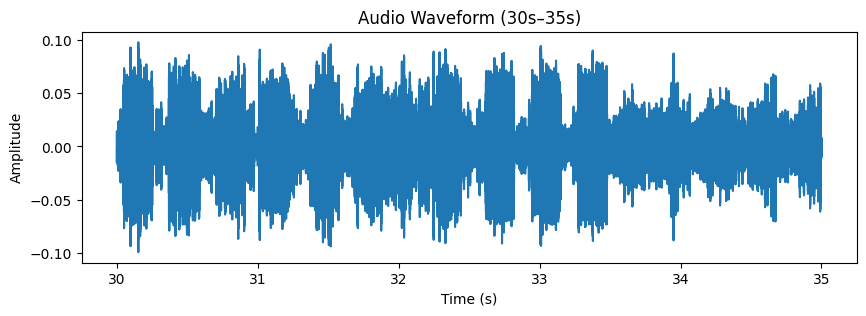

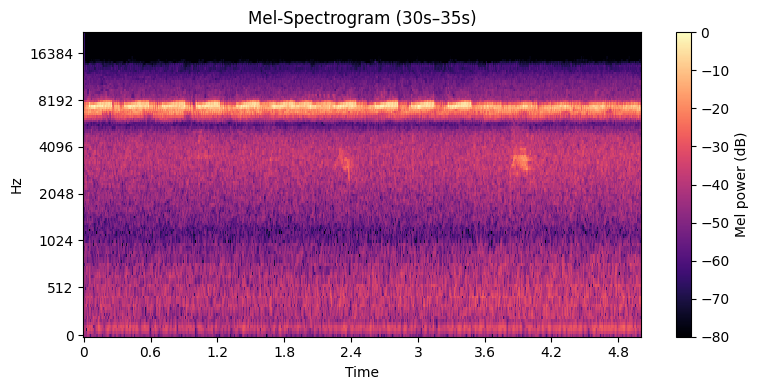

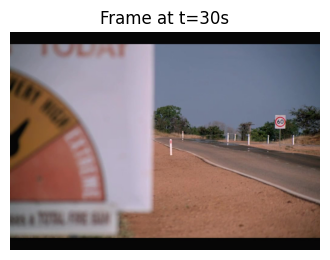

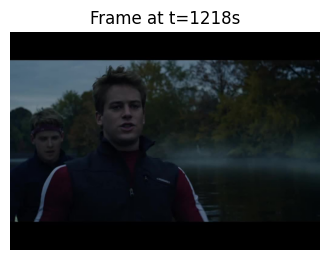

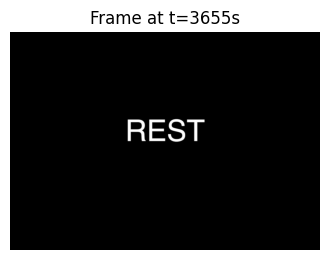

In [8]:
import matplotlib.pyplot as plt
import librosa.display

# Grab 5 seconds of audio to visualize
t_start, t_end = 30, 35
audio_snippet = y[int(t_start*sr): int(t_end*sr)]
time_axis = np.linspace(t_start, t_end, len(audio_snippet))

# Plot the raw waveform for this snippet
plt.figure(figsize=(10, 3))
plt.plot(time_axis, audio_snippet)
plt.title(f"Audio Waveform ({t_start}s–{t_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Show the mel-spectrogram for the same 5-second window
S = librosa.feature.melspectrogram(y=audio_snippet, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(8, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=256, x_axis='time', y_axis='mel')
plt.colorbar(label='Mel power (dB)')
plt.title(f"Mel-Spectrogram ({t_start}s–{t_end}s)")
plt.tight_layout()
plt.show()

# Show a few sample video frames: early, middle, and end
sample_times = [30, duration//3, duration]
for t in sample_times:
    frame_path = f"frames/frame_{t:04d}.jpg"
    if not os.path.exists(frame_path):
        continue
    img = Image.open(frame_path).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Frame at t={t}s")
    plt.axis('off')
    plt.show()


In [9]:
print("Shape of y:", y.shape)
print("Sample rate (sr):", sr)
print("Min:", np.min(y), "Max:", np.max(y), "Mean:", np.mean(y), "Std:", np.std(y))
print("First 10 values:", y[:10])


Shape of y: (161186816,)
Sample rate (sr): 44100
Min: -0.95988464 Max: 0.9093323 Mean: -1.618905e-05 Std: 0.020298308
First 10 values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


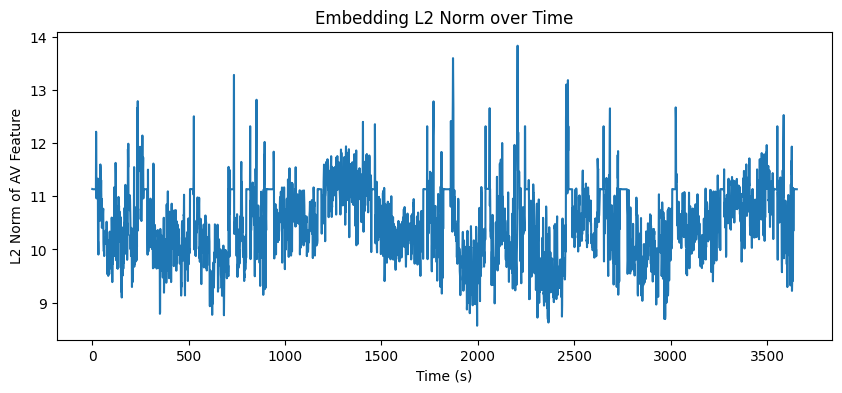

Explained variance by first 2 PCA components: [0.4194297  0.05991843]


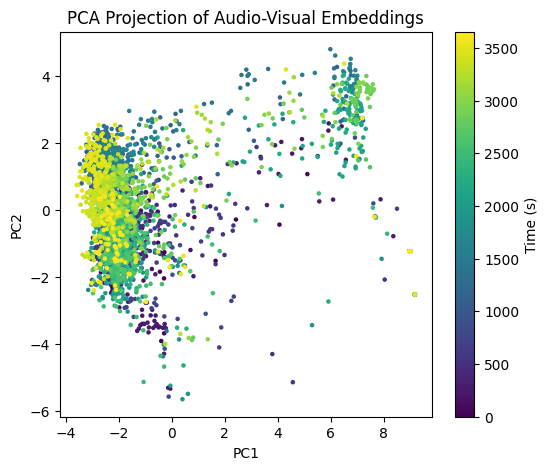

In [10]:
# Compute L2 norm of each embedding vector
embeddings_norm = np.linalg.norm(embeddings, axis=1)
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(embeddings_norm)), embeddings_norm)
plt.title("Embedding L2 Norm over Time")
plt.xlabel("Time (s)")
plt.ylabel("L2 Norm of AV Feature")
plt.show()

# PCA to 2 dimensions for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)
print("Explained variance by first 2 PCA components:", pca.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
sc = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=np.arange(len(embeddings)), cmap='viridis', s=5)
plt.colorbar(sc, label="Time (s)")
plt.title("PCA Projection of Audio-Visual Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [11]:
import scipy.io

scipy.io.savemat("audiovisual_features.mat", {"audiovisual_embeddings": embeddings})
print("Saved embeddings to 'audiovisual_features.mat'")



Saved embeddings to 'audiovisual_features.mat'
